# Imports

In [1]:
from glob import glob
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# Calibrate the camera

In [2]:
CALIBRATION_IMAGES = "camera_cal/*.jpg"
CALIBRATION_IMAGE_COLS = 9
CALIBRATION_IMAGE_ROWS = 6

In [3]:
objpoints = [] # 3d points in real world space, can be logical from model
imgpoints = [] # 2d points on image plane, from photo


# Fill the logical points locations. shape = (54,3), 3rd column stays zero
objp = np.zeros(((CALIBRATION_IMAGE_COLS*CALIBRATION_IMAGE_ROWS),3), np.float32) # shape: (54, 3)
objp[:,:2] = np.mgrid[0:CALIBRATION_IMAGE_COLS,0:CALIBRATION_IMAGE_ROWS].T.reshape(-1,2) # Fills the first two columns of objp with a (54,2) combination of indexes 

def findChessboardCorners(fname):
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_shape = gray.shape[::-1] # shape is the way to get the image size

    # Detect and register points
    ret, corners = cv2.findChessboardCorners(gray, (CALIBRATION_IMAGE_COLS, CALIBRATION_IMAGE_ROWS), None)
    return ret, corners, img_shape

# Load, preprocess and find corners for all images
images = glob(CALIBRATION_IMAGES)
img_shape = None
for fname in images:
    ret, corners, img_shape = findChessboardCorners(fname)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

# Compute coefficients (TODO: Is the img_shape for the original images, or for target images?)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)  

# Create undistort function
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)


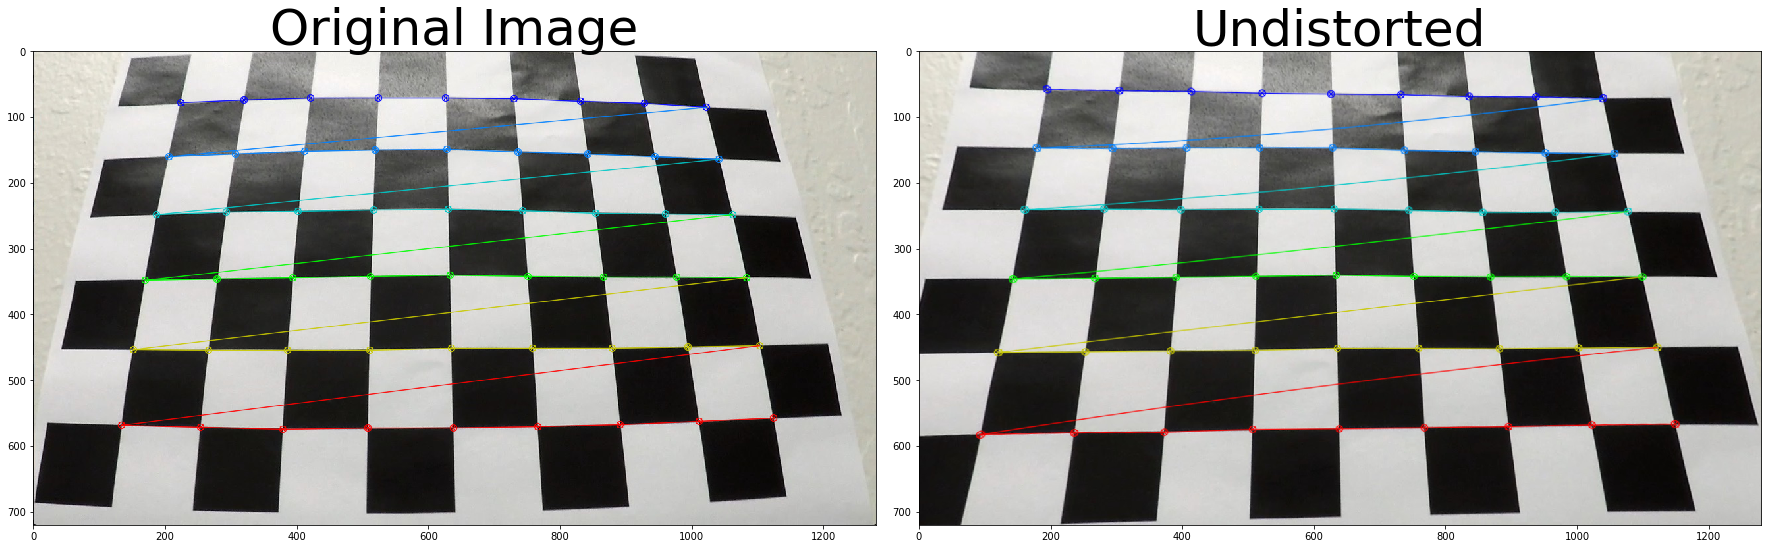

In [4]:
# Visualize 
vis_img_fname = images[13]
ret, corners, _ = findChessboardCorners(vis_img_fname)

if not ret:
    raise Exception('Could not detect corners in ' + vis_img_fname)
img = mpimg.imread(vis_img_fname)
img = cv2.drawChessboardCorners(img, (CALIBRATION_IMAGE_COLS, CALIBRATION_IMAGE_ROWS), corners, ret)
dst= undistort(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Process input image:
1. Correct distortion
2. Color, gradient, threshold for lane pixels
3. Perspective transform
4. Find lane pixels, fit a lane boundary
5. Determine lane curvature and position with relation to center
6. Warp back to original image

# TODO:
1. Curvature measurement
2. Adjust parameters
3. Process video
3.0 Load frames from video
3.1 Render on original
3.2 Print curvature and position
3.3 Save video
3.4 ? Optimized search ? Smoothing ?

# Configuration for perspective transform

In [102]:
VIDEO_HEIGHT = 720
VIDEO_WIDTH = 1280
TRAPEZE_TOP_MARGIN = 587
TRAPEZE_BOTTOM_MARGIN = 130
TRAPEZE_TOP = 450
PAD=0

# Calculate trapezoid and matrices for perspective transform

In [103]:
# Source points - Trapezoid
top_left = (TRAPEZE_TOP_MARGIN, TRAPEZE_TOP)
top_right = (VIDEO_WIDTH - TRAPEZE_TOP_MARGIN, TRAPEZE_TOP)
low_left = (TRAPEZE_BOTTOM_MARGIN, VIDEO_HEIGHT)
low_right = (VIDEO_WIDTH - TRAPEZE_BOTTOM_MARGIN, VIDEO_HEIGHT)
src = np.float32([top_left, top_right, low_right, low_left])

width = VIDEO_WIDTH-PAD
height = VIDEO_HEIGHT-PAD
dst = np.float32([[PAD,PAD],[width,PAD],[width,height],[PAD,height]])

m = cv2.getPerspectiveTransform(src, dst)
m_inverse = cv2.getPerspectiveTransform(dst, src)

def perspectiveToTop(img):
    return cv2.warpPerspective(img, m, (VIDEO_WIDTH, VIDEO_HEIGHT), flags=cv2.INTER_LINEAR)


# Visualize on sample images

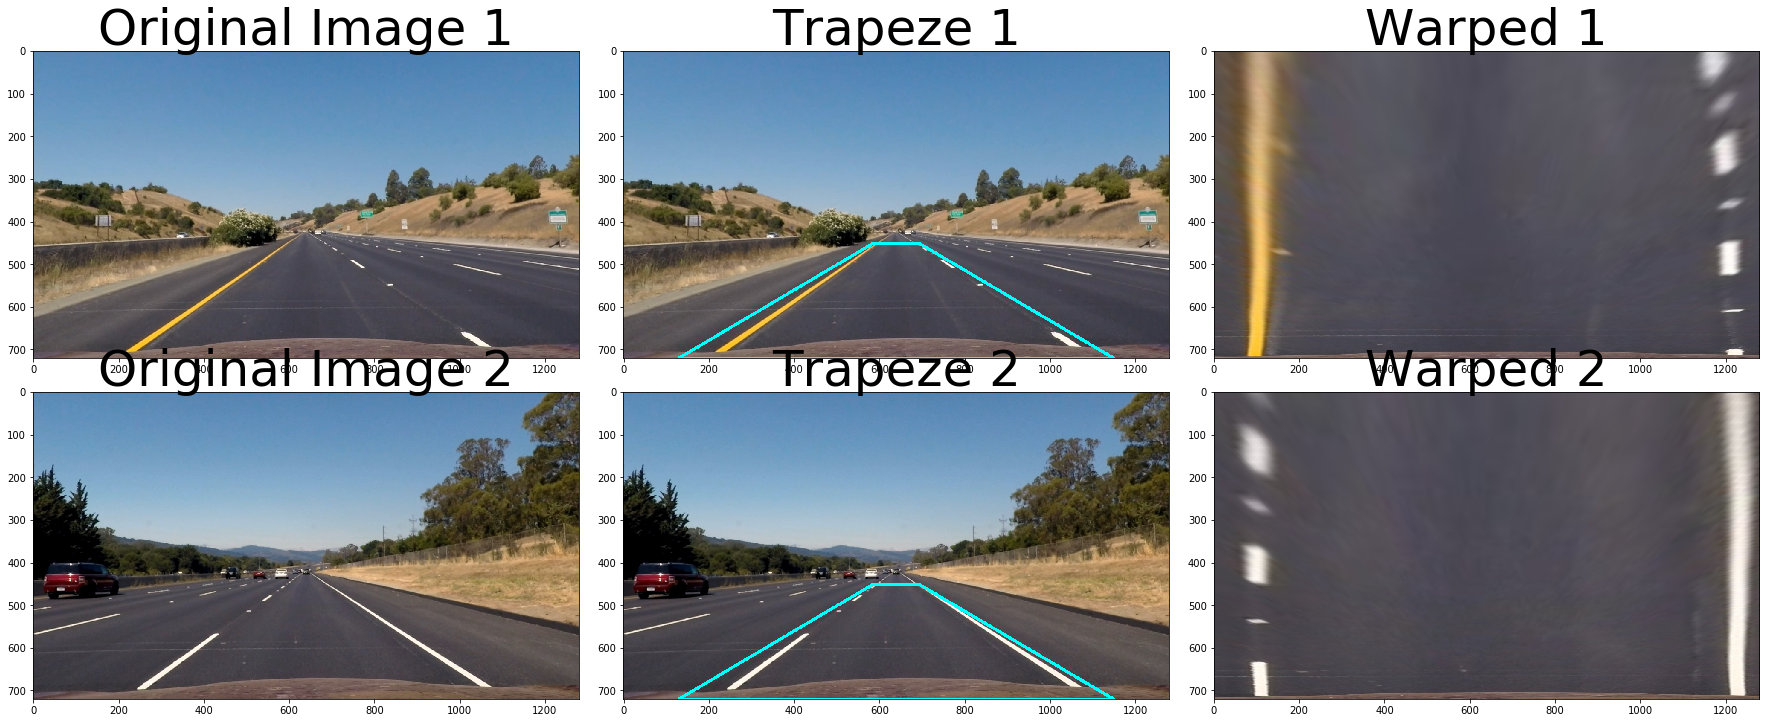

In [104]:

# Draw the trapeze for sample images
straight_lines_img1 = plt.imread('test_images/straight_lines1.jpg')
straight_lines_img2 = plt.imread('test_images/straight_lines2.jpg')

straight_lines_img1 = undistort(straight_lines_img1)
straight_lines_img2 = undistort(straight_lines_img2)

pts = np.array([[top_left,top_right,low_right, low_left]], np.int32)
pts = pts.reshape((-1,1,2))
straight_lines_img1_with_trapeze = np.copy(straight_lines_img1)
cv2.polylines(straight_lines_img1_with_trapeze,[pts],True,(0,255,255), thickness=5)
straight_lines_img2_with_trapeze = np.copy(straight_lines_img2)
cv2.polylines(straight_lines_img2_with_trapeze,[pts],True,(0,255,255), thickness=5)

# image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
straight_lines_img1_from_top = perspectiveToTop(straight_lines_img1)
straight_lines_img2_from_top = perspectiveToTop(straight_lines_img2)


f, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(straight_lines_img1)
ax1.set_title('Original Image 1', fontsize=50)
ax2.imshow(straight_lines_img1_with_trapeze)
ax2.set_title('Trapeze 1', fontsize=50)
ax3.imshow(straight_lines_img1_from_top)
ax3.set_title('Warped 1', fontsize=50)

ax4.imshow(straight_lines_img2)
ax4.set_title('Original Image 2', fontsize=50)
ax5.imshow(straight_lines_img2_with_trapeze)
ax5.set_title('Trapeze 2', fontsize=50)
ax6.imshow(straight_lines_img2_from_top)
ax6.set_title('Warped 2', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=1.0, bottom=0.)


# Extract features, threshold and combine

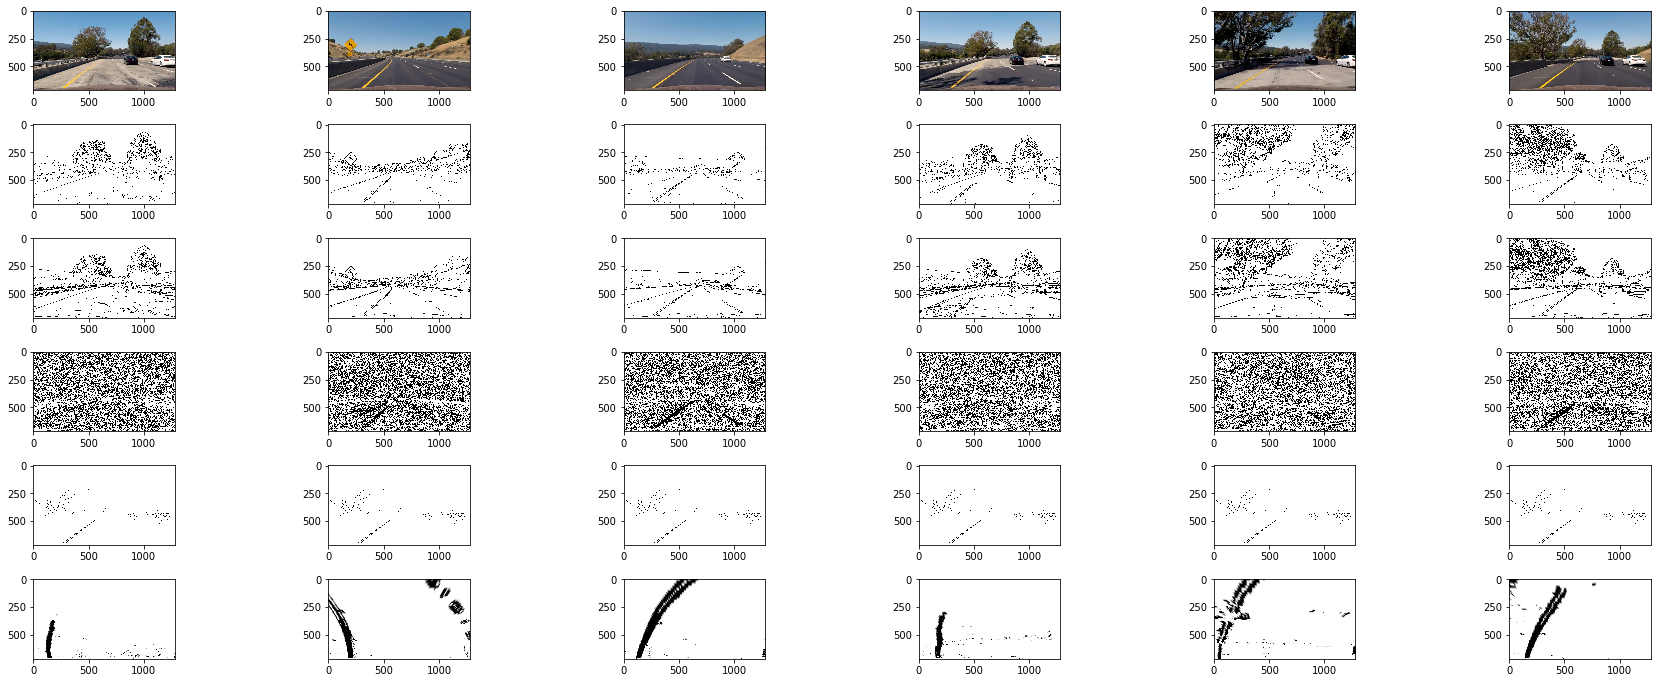

In [105]:
# Attribution: Function from lesson 21 in the project
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(grayscale_img, orient='x', thresh_min=0, thresh_max=255):

    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(grayscale_img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(grayscale_img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def mag_thresh(grayscale_img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # 1) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(grayscale_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(grayscale_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Calculate the magnitude 
    sobel = np.sqrt(sobel_x**2+sobel_y**2)
    
    # 2) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(grayscale_img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(grayscale_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(grayscale_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.abs(sobel_x)
    abs_sobel_y = np.abs(sobel_y)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobel_y, abs_sobel_x)
    
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return binary_output
    
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    s_chan = hls[:,:,2]
    binary_output = np.zeros_like(s_chan)
    binary_output[(s_chan > thresh[0]) & (s_chan <= thresh[1])]=1
    # 3) Return a binary image of threshold result
    return binary_output
    
def combine_thresholds(test_img):
    test_img_gray = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)
    test_img_grad_x = abs_sobel_thresh(test_img_gray, orient='x', thresh_min=20, thresh_max=100)
    test_img_grad_mag = mag_thresh(test_img_gray, sobel_kernel=3, mag_thresh=(30,200))
    test_img_grad_dir = dir_threshold(test_img_gray, sobel_kernel=15, thresh=(0.7, 1.3))
    test_img_h_chan = hls_select(test_img, thresh=(170, 255))

    
    combined = np.zeros_like(test_img_grad_dir)
    combined[
        ((test_img_grad_x == 1) & (test_img_grad_x == 1)) | 
        ((test_img_grad_mag == 1) & (test_img_grad_dir == 1)) |
        (test_img_h_chan == 1)
    ] = 1
    
    return (combined, test_img_grad_x, test_img_grad_mag, test_img_grad_dir)
    

# Show on test images
f, axes = plt.subplots(6, 6, figsize=(24, 9))
f.tight_layout()
test_fnames = glob('test_images/test*.jpg')
for idx, fname in enumerate(test_fnames[0:6]):
    test_img = plt.imread(fname)
    test_img = undistort(test_img)
    (combined, test_img_grad_x, test_img_grad_mag, test_img_grad_dir) = combine_thresholds(test_img)
    combined_from_top = perspectiveToTop(combined)
    
#     test_img_from_top = perspectiveToTop(test_img)
    axes[0, idx].imshow(test_img, cmap='Greys')
    axes[1, idx].imshow(test_img_grad_x, cmap='Greys')
    axes[2, idx].imshow(test_img_grad_mag, cmap='Greys')
    axes[3, idx].imshow(test_img_grad_dir, cmap='Greys')
    axes[4, idx].imshow(test_img_h_chan, cmap='Greys')
    axes[5, idx].imshow(combined, cmap='Greys')
    axes[5, idx].imshow(combined_from_top, cmap='Greys')


plt.subplots_adjust(left=0., right=1, top=1.0, bottom=0.)

# Exercise code to find peaks and pixels which belong to the lanes

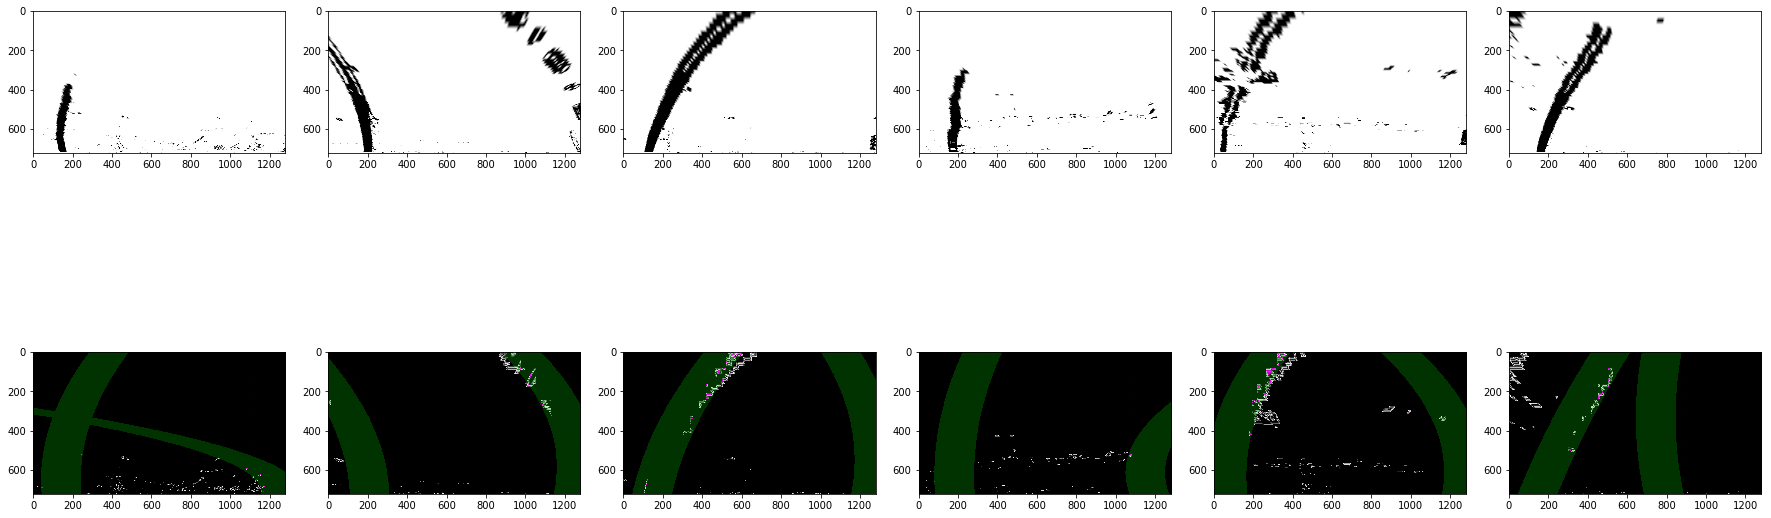

In [106]:
def find_starting_position_unhinted(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return (leftx_base, rightx_base)

def search_lane_pixels(binary_warped, leftx_base, rightx_base, out_img):
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    return (left_lane_inds, right_lane_inds, nonzerox, nonzeroy)

def fit_polynomial(left_lane_inds, right_lane_inds, nonzerox, nonzeroy):

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return (left_fit, right_fit)


def plot_with_polynomial(binary_warped, left_fit, right_fit, out_img):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Create an image to draw on and an image to show the selection window
    window_img = np.zeros_like(out_img)
    
    # Set the width of the windows +/- margin
    margin = 100

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return result
    
    
    
# Show on test images
f, axes = plt.subplots(2, 6, figsize=(24, 9))
f.tight_layout()
test_fnames = glob('test_images/test*.jpg')
for idx, fname in enumerate(test_fnames[0:6]):
    test_img = plt.imread(fname)
    test_img = undistort(test_img)
    (combined, _, _, _) = combine_thresholds(test_img)
    combined_from_top = perspectiveToTop(combined)
    
    # Create an output image (color) to draw on and visualize the result
    out_img = np.dstack((combined_from_top, combined_from_top, combined_from_top))*255
    
    (leftx_base, rightx_base) = find_starting_position_unhinted(combined_from_top)
    (left_lane_inds, right_lane_inds, nonzerox, nonzeroy) = search_lane_pixels(combined_from_top, leftx_base, rightx_base, out_img)
    (left_fit, right_fit) = fit_polynomial(left_lane_inds, right_lane_inds, nonzerox, nonzeroy)
    
    out_img = plot_with_polynomial(combined_from_top, left_fit, right_fit, out_img)
    
    axes[0, idx].imshow(combined_from_top, cmap='Greys')
    axes[1, idx].imshow(out_img)


plt.subplots_adjust(left=0., right=1, top=1.0, bottom=0.)

# Exercise code to measure curvature (CHANGE to use actual lanes)

In [77]:
# # Generate some fake data to represent lane-line pixels
# ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
# quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# # For each y position generate random x position within +/-50 pix
# # of the line base position in each case (x=200 for left, and x=900 for right)
# leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                               for y in ploty])
# rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                                 for y in ploty])
leftx = left_line_pts[:,0,0]
lefty = left_line_pts[:,1,0]
rightx = right_line_pts[:,0,0]
righty = right_line_pts[:,1,0]
print(left_line_pts)
print(leftx, lefty)

# # leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
# # rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# # Fit a second order polynomial to pixel positions in each fake lane line
# left_fit = np.polyfit(lefty, leftx, 2)
# left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
# right_fit = np.polyfit(righty, rightx, 2)
# right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]

# # Plot up the fake data
# mark_size = 3
# plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
# plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
# plt.xlim(0, 1280)
# plt.ylim(0, 720)
# plt.plot(left_fitx, ploty, color='green', linewidth=3)
# plt.plot(right_fitx, ploty, color='green', linewidth=3)
# plt.gca().invert_yaxis() # to visualize as we do the images

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

NameError: name 'left_line_pts' is not defined

# Process the video

In [ ]:
# cap = cv2.VideoCapture('project_video.mp4')
# # Get first frame for visualization
# ret, frame = cap.read()
# cap.release()

# frame_bg = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
# frame_bg_undistorted = undistort(frame_bg)
# plt.imshow(frame_bg_undistorted)

# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
# f.tight_layout()
# ax1.imshow(img)
# ax1.set_title('Straight ', fontsize=50)
# ax2.imshow(dst)
# ax2.set_title('Undistorted', fontsize=50)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# while(cap.isOpened()):
#     ret, frame = cap.read()

#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#     cv2.imshow('frame',gray)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# cv2.destroyAllWindows()